In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline

(2400, 1080, 3)

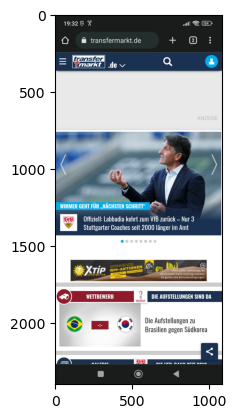

In [3]:
PATH = '../app/src/androidTest/assets/defective/Screenshot_2022-12-05-19-32-46-561_com.android.chrome.jpg'

img = mpimg.imread(PATH)
plt.imshow(img)
img.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2400, 1080, 3)

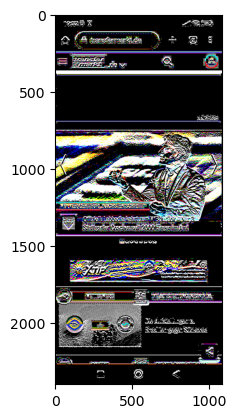

In [21]:
def sobel(image, dy):
    return cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=0, dy=dy, ksize=5)

sobel_y_1d = sobel(img, 1)
sobel_y_2d = sobel(img, 2)

plt.imshow(sobel_y_1d)

sobel_y_2d.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


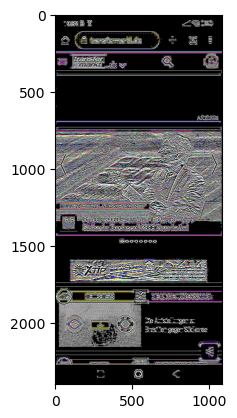

In [22]:
plt.imshow(sobel_y_2d)

(2400, 1080)

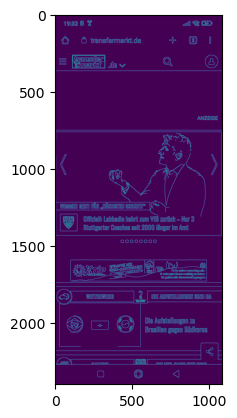

In [26]:
canny = cv2.Canny(img, 100, 200)
plt.imshow(canny)
canny.shape

(2400, 1080)

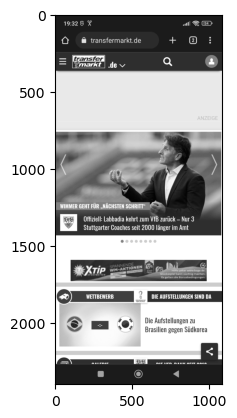

In [12]:
img_gray = np.asarray(Image.open(PATH).convert('L'))
plt.imshow(img_gray, cmap='gray')
img_gray.shape

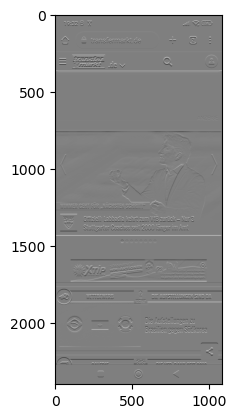

In [23]:
sobel_y_gray = sobel(img_gray, 1)
plt.imshow(sobel_y_gray, cmap='gray')

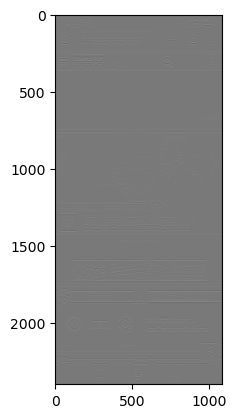

In [24]:
sobel_y_gray = sobel(img_gray, 2)
plt.imshow(sobel_y_gray, cmap='gray')

array([  0, 255], dtype=uint8)

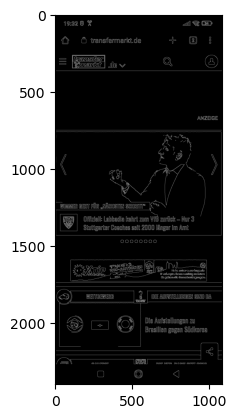

In [35]:
canny_gray = cv2.Canny(img_gray, 100, 200)
plt.imshow(canny_gray, cmap='gray')
np.unique(canny_gray.flatten())

In [39]:
for i, row in enumerate(canny_gray):
    if np.mean(row) > 200:
        print(i)

368
753
1435
1733
1741
1768
1796
2184
2211
2239
